In [1]:
#imports
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

In [2]:
#import climatology estimates
clim = pd.read_hdf('./tmp2m_2degree_clim_per_monthday.h5')
clim.reset_index(inplace=True)
clim['date2'] = clim['day'].astype(str).str.zfill(2)
clim['month2'] = clim['month'].astype(str).str.zfill(2)
clim['latlon'] = clim['lat'].astype(str) + '|' + clim['lon'].astype(str)
clim = clim.rename(columns={'tmp2m':'climatology'})
clim['mdll'] = clim['month2'] + "|" + clim['date2'] + "|" + clim['latlon']
clim = clim.drop(columns=['day','month','lat','lon','date2','month2','latlon'])
clim

,climatology,mdll
0,14.497499,01|01|27.25|261.75
1,18.786179,01|01|27.25|277.75
2,19.804401,01|01|27.25|279.75
3,11.854734,01|01|29.25|259.75
4,11.591003,01|01|29.25|261.75
...,...,...
72097,-13.737334,12|31|47.25|265.75
72098,-12.292819,12|31|47.25|267.75
72099,-10.741566,12|31|47.25|269.75
72100,-7.545133,12|31|47.25|271.75


In [3]:
#load and format testset
df_test = pd.read_csv("results_test.csv", encoding="utf-8")
df_test['err'] = df_test['xgboost_tmp2m_pred'] - df_test['tmp2m']
df_test['lon2'] = df_test['lon']-360
df_test['latlon'] = df_test['lat'].astype(str) + "|" + df_test['lon'].astype(str)
df_test['start_date'] = pd.to_datetime(df_test['start_date'])
df_test['month'] = pd.DatetimeIndex(df_test['start_date']).month
df_test['month2'] = df_test['month'].astype(str).str.zfill(2)
df_test['year'] = pd.DatetimeIndex(df_test['start_date']).year
df_test['yearmonth'] = df_test['year'].astype(str) + '-' + df_test['month2'].astype(str)
df_test['date'] = pd.DatetimeIndex(df_test['start_date']).day
df_test['date2'] = df_test['date'].astype(str).str.zfill(2)
df_test['err'] = round(df_test['err'],3)
df_test['phys_err'] = round(df_test['phys_err'],3)

#Seasons
def season (x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'fall'

#Locations
locations = pd.read_csv("locations.csv", encoding="utf-8")
locations.rename(columns={"Location": "latlon"}, inplace=True)
locations.sort_values(by=['latlon'], ascending=False)


#Map season and location and extremes
df_test['season'] = df_test['month'].apply(season)
df_test = pd.merge(df_test, locations, on='latlon')
df_test['heatwave'] = df_test['tmp2m'] >34
df_test['coldwave'] = df_test['tmp2m'] <-10

#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

df_test['mdll'] = df_test['month2'] + "|" + df_test['date2'] + "|" + df_test['latlon']
df_test

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,yearmonth,date,date2,season,State,Sub-Region,Region,heatwave,coldwave,mdll
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,2019-10,1,01,fall,Texas,West South Central,South,False,False,10|01|27.25|261.75
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,2019-10,8,08,fall,Texas,West South Central,South,False,False,10|08|27.25|261.75
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,2019-10,15,15,fall,Texas,West South Central,South,False,False,10|15|27.25|261.75
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,2019-10,22,22,fall,Texas,West South Central,South,False,False,10|22|27.25|261.75
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,2019-10,29,29,fall,Texas,West South Central,South,False,False,10|29|27.25|261.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-06-29|47.25|273.75,2021-06-29,47.25,273.75,-0.061508,15.384313,2.808936,0.734029,17.446154,15.211542,...,2021-06,29,29,summer,Michigan,East North Central,Midwest,False,False,06|29|47.25|273.75
26394,2020-07-07|47.25|273.75,2020-07-07,47.25,273.75,-0.408582,16.091479,2.732136,-0.339037,15.165182,14.975177,...,2020-07,7,07,summer,Michigan,East North Central,Midwest,False,False,07|07|47.25|273.75
26395,2020-07-14|47.25|273.75,2020-07-14,47.25,273.75,-0.268441,16.598514,2.503675,-0.350005,15.722215,15.926424,...,2020-07,14,14,summer,Michigan,East North Central,Midwest,False,False,07|14|47.25|273.75
26396,2020-07-21|47.25|273.75,2020-07-21,47.25,273.75,-0.357121,16.739847,2.226671,0.118659,17.004061,15.944656,...,2020-07,21,21,summer,Michigan,East North Central,Midwest,False,False,07|21|47.25|273.75


In [4]:
#merge the test data with climatology to generate a new test set
df_test2 = pd.merge(df_test, clim, on='mdll')
df_test2

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,date,date2,season,State,Sub-Region,Region,heatwave,coldwave,mdll,climatology
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,1,01,fall,Texas,West South Central,South,False,False,10|01|27.25|261.75,26.046652
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,8,08,fall,Texas,West South Central,South,False,False,10|08|27.25|261.75,24.252977
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,15,15,fall,Texas,West South Central,South,False,False,10|15|27.25|261.75,24.302401
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,22,22,fall,Texas,West South Central,South,False,False,10|22|27.25|261.75,22.604475
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,29,29,fall,Texas,West South Central,South,False,False,10|29|27.25|261.75,21.669365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-06-29|47.25|273.75,2021-06-29,47.25,273.75,-0.061508,15.384313,2.808936,0.734029,17.446154,15.211542,...,29,29,summer,Michigan,East North Central,Midwest,False,False,06|29|47.25|273.75,12.652040
26394,2020-07-07|47.25|273.75,2020-07-07,47.25,273.75,-0.408582,16.091479,2.732136,-0.339037,15.165182,14.975177,...,7,07,summer,Michigan,East North Central,Midwest,False,False,07|07|47.25|273.75,13.627860
26395,2020-07-14|47.25|273.75,2020-07-14,47.25,273.75,-0.268441,16.598514,2.503675,-0.350005,15.722215,15.926424,...,14,14,summer,Michigan,East North Central,Midwest,False,False,07|14|47.25|273.75,15.112576
26396,2020-07-21|47.25|273.75,2020-07-21,47.25,273.75,-0.357121,16.739847,2.226671,0.118659,17.004061,15.944656,...,21,21,summer,Michigan,East North Central,Midwest,False,False,07|21|47.25|273.75,15.676359


In [34]:
#add climatology error
#df_test2['clim_err'] = df_test2['climatology'] - df_test2['tmp2m']
wt_xgb = 1
wt_clim = 0

df_test2['clim_err'] = df_test2['tmp2m_daily_mean']-df_test2['tmp2m']
df_test2['ens'] = wt_xgb*(df_test2['xgboost_tmp2m_pred']) + wt_clim*(df_test2['tmp2m_daily_mean'])
df_test2['ens_err'] = df_test2['ens'] - df_test2['tmp2m']
df_test2['ml_outperforms_climatology'] = abs(df_test2['err']) < abs(df_test2['clim_err'])
df_test2['phys_outperforms_climatology'] = abs(df_test2['phys_err']) < abs(df_test2['clim_err'])
df_test2['ens_outperforms_climatology'] = abs(df_test2['ens_err']) < abs(df_test2['clim_err'])
df_test2

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,mdll,climatology,clim_err,ens,ens_err,ml_outperforms_climatology,phys_outperforms_climatology,ens_outperforms_climatology,abs_ens_err,abs_clim_err
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,10|01|27.25|261.75,26.046652,0.030342,24.973697,2.133071,False,False,False,0.240615,0.030342
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,10|08|27.25|261.75,24.252977,2.555389,23.893391,4.726898,False,True,False,2.772540,2.555389
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,10|15|27.25|261.75,24.302401,2.207993,22.889792,4.422631,False,True,False,2.429457,2.207993
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,10|22|27.25|261.75,22.604475,4.370598,21.507993,6.426617,False,True,False,4.576200,4.370598
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,10|29|27.25|261.75,21.669365,2.804756,20.624798,4.911374,False,True,False,3.015418,2.804756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26393,2021-06-29|47.25|273.75,2021-06-29,47.25,273.75,-0.061508,15.384313,2.808936,0.734029,17.446154,15.211542,...,06|29|47.25|273.75,12.652040,-2.061841,15.211542,-2.234612,False,False,False,2.079118,2.061841
26394,2020-07-07|47.25|273.75,2020-07-07,47.25,273.75,-0.408582,16.091479,2.732136,-0.339037,15.165182,14.975177,...,07|07|47.25|273.75,13.627860,0.926297,14.975177,-0.190005,True,False,True,0.814666,0.926297
26395,2020-07-14|47.25|273.75,2020-07-14,47.25,273.75,-0.268441,16.598514,2.503675,-0.350005,15.722215,15.926424,...,07|14|47.25|273.75,15.112576,0.876299,15.926424,0.204209,True,False,True,0.809090,0.876299
26396,2020-07-21|47.25|273.75,2020-07-21,47.25,273.75,-0.357121,16.739847,2.226671,0.118659,17.004061,15.944656,...,07|21|47.25|273.75,15.676359,-0.264214,15.944656,-1.059405,False,False,False,0.343733,0.264214


In [30]:
#Functions / Metrics
def mbe (x):
    return round(np.mean(x),3)

def mae (x):
    return round(np.mean(abs(x)), 3)

def sd (x):
    return round(np.std(x), 3)

#def r2 (x):
#    return round(np.std(x), 3)


In [31]:
df_test2['abs_clim_err'] = abs(df_test2['tmp2m_daily_mean']-df_test2['tmp2m'])
clim_mae = df_test2.abs_clim_err.mean()
clim_mae

1.854952697884631

In [32]:
df_test2['abs_ens_err'] = abs(df_test2['ens_err'])
ens_mae = df_test2.abs_ens_err.mean()
ens_mae

1.8528382958326954

In [33]:
mae_red = (clim_mae - ens_mae) / clim_mae
print(round(mae_red,3))

0.001


In [184]:
#Climatology comparisons by State
indexlist = ['State']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_ens_err":"Vayuh MBE", "mae_ens_err":"Vayuh MAE", "sd_ens_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata = pd.merge(chartdata, climpivot, on=indexlist)
chartdata['ml>clim'] = chartdata['Vayuh MAE'] < chartdata['Climatology MAE']
chartdata['phys>clim'] = chartdata['Physics MAE'] < chartdata['Climatology MAE']
#def this later
chartdata['MAE Reduction'] = (chartdata['Climatology MAE'] - chartdata['Vayuh MAE'])/chartdata['Climatology MAE']
chartdata

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
State,,,,,,,,,,,,
Alabama,-0.644,1.612,2.036,-3.357,6.564,7.815,-0.723,1.632,2.032,True,False,0.012255
Arizona,-0.649,1.618,1.942,-5.129,8.386,9.602,-0.742,1.652,1.947,True,False,0.020581
Arkansas,0.382,1.595,2.185,-3.425,7.265,9.287,0.357,1.591,2.180,False,False,-0.002514
California,-0.251,1.543,1.923,-3.913,7.453,8.953,-0.306,1.558,1.926,True,False,0.009628
Colorado,-0.258,1.739,2.220,-2.740,7.651,10.134,-0.307,1.746,2.213,True,False,0.004009
Florida,-0.630,1.246,1.545,-1.843,4.125,4.935,-0.716,1.262,1.536,True,False,0.012678
Georgia,-0.855,1.557,1.887,-3.889,6.810,7.538,-0.961,1.582,1.871,True,False,0.015803
Idaho,-0.178,1.791,2.311,-5.047,8.976,10.496,-0.186,1.795,2.316,True,False,0.002228
Illinois,0.299,1.895,2.610,-3.671,8.654,10.838,0.265,1.892,2.607,False,False,-0.001586


In [112]:
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata, on='State')
gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,geometry,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
0,37,01027616,0400000US37,37,NC,North Carolina,00,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",0.149,1.615,2.021,-4.590,7.770,8.561,-1.014,2.555,2.983,True,False,0.367906
1,40,01102857,0400000US40,40,OK,Oklahoma,00,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",0.536,1.812,2.573,-2.686,7.105,9.653,-0.198,2.879,3.705,True,False,0.370615
2,51,01779803,0400000US51,51,VA,Virginia,00,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",0.194,1.736,2.232,-4.754,8.170,9.234,-1.111,2.718,3.155,True,False,0.361295
3,54,01779805,0400000US54,54,WV,West Virginia,00,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",0.013,1.713,2.221,-5.200,8.864,9.944,-0.990,3.073,3.562,True,False,0.442564
4,22,01629543,0400000US22,22,LA,Louisiana,00,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",0.298,1.525,2.097,-2.701,6.121,7.841,-0.353,2.253,3.015,True,False,0.323125
5,26,01779789,0400000US26,26,MI,Michigan,00,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",-0.025,2.093,2.672,-4.148,8.629,10.268,-0.992,3.346,3.983,True,False,0.374477
6,16,01779783,0400000US16,16,ID,Idaho,00,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",-0.102,1.931,2.546,-5.047,8.976,10.496,-0.668,3.154,3.874,True,False,0.387762
7,12,00294478,0400000US12,12,FL,Florida,00,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",0.138,1.312,1.795,-1.843,4.125,4.935,-0.916,1.739,2.097,True,False,0.245543
8,31,01779792,0400000US31,31,NE,Nebraska,00,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",0.342,2.474,3.475,-3.892,9.549,11.835,-0.600,3.662,4.600,True,False,0.324413
9,53,01779804,0400000US53,53,WA,Washington,00,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",0.039,1.920,2.643,-5.177,8.746,9.513,-0.809,3.020,3.584,True,False,0.364238


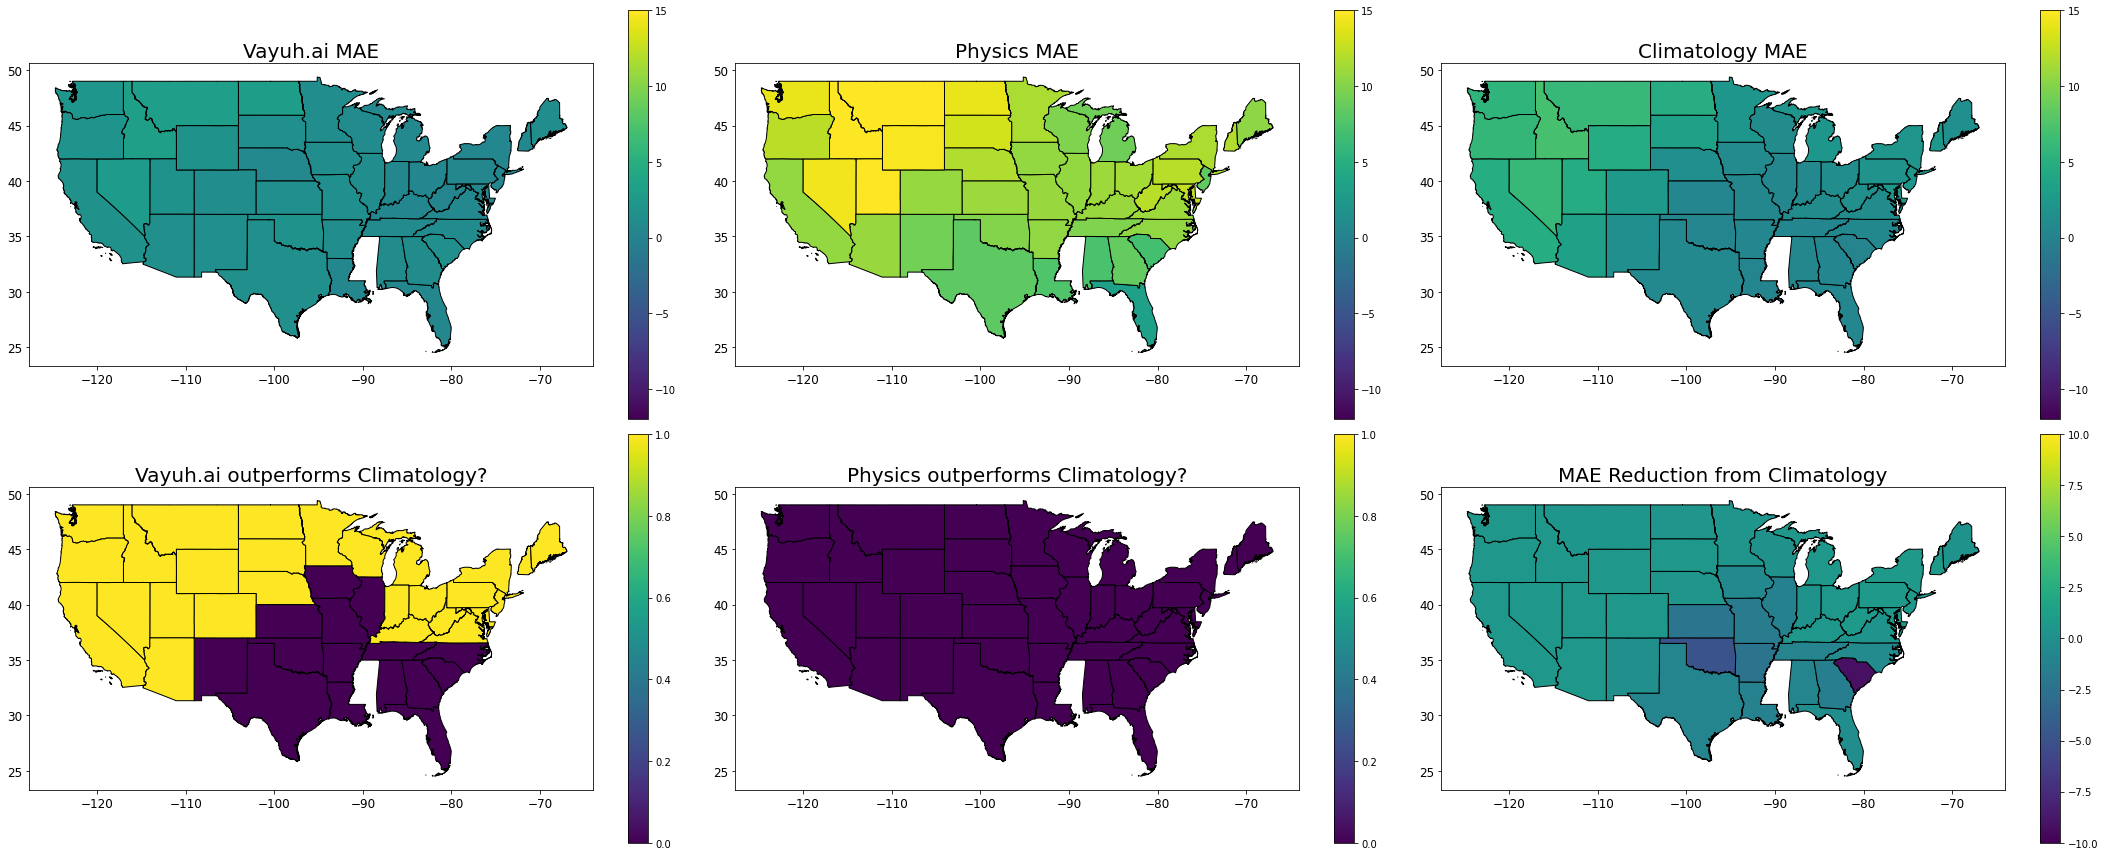

In [101]:
#By State
fig, axes = plt.subplots(figsize=(30,12), nrows = 2, ncols=3)
gdf.plot(ax=axes[0,0], column='Vayuh MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0,0].set_title('Vayuh.ai MAE', fontsize=20)
axes[0,0].tick_params(labelsize=12)
gdf.plot(ax=axes[0,1], column='Physics MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0,1].set_title('Physics MAE', fontsize=20)
axes[0,1].tick_params(labelsize=12)
gdf.plot(ax=axes[0,2], column='Climatology MAE', cmap='viridis', vmax=15, vmin=-12, linewidth=1, edgecolor='black', legend=True)
axes[0,2].set_title('Climatology MAE', fontsize=20)
axes[0,2].tick_params(labelsize=12)
gdf.plot(ax=axes[1,0], column='ml>clim', cmap='viridis', vmax=1, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[1,0].set_title('Vayuh.ai outperforms Climatology?', fontsize=20)
axes[1,0].tick_params(labelsize=12)
gdf.plot(ax=axes[1,1], column='phys>clim', cmap='viridis', vmax=1, vmin=0, linewidth=1, edgecolor='black', legend=True)
axes[1,1].set_title('Physics outperforms Climatology?', fontsize=20)
axes[1,1].tick_params(labelsize=12)
gdf.plot(ax=axes[1,2], column='MAE Reduction', cmap='viridis', vmax=10, vmin=-10, linewidth=1, edgecolor='black', legend=True)
axes[1,2].set_title('MAE Reduction from Climatology', fontsize=20)
axes[1,2].tick_params(labelsize=12)
fig.tight_layout()

In [148]:
#Climatology comparisons by Time
indexlist = ['start_date']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata2 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata2 = pd.merge(chartdata2, climpivot, on=indexlist)
chartdata2['ml>clim'] = chartdata2['Vayuh MAE'] < chartdata2['Climatology MAE']
chartdata2['phys>clim'] = chartdata2['Physics MAE'] < chartdata2['Climatology MAE']
#def this later
chartdata2['MAE Reduction'] = (chartdata2['Climatology MAE'] - chartdata2['Vayuh MAE'])/chartdata2['Climatology MAE']
chartdata2

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
start_date,,,,,,,,,,,,
2019-01-01,1.250,1.696,2.124,2.038,2.922,3.910,0.654,1.594,2.155,False,False,-0.063990
2019-01-08,1.604,2.156,2.762,2.044,3.245,4.450,0.985,1.935,2.742,False,False,-0.114212
2019-01-15,2.361,3.392,4.017,2.409,4.403,5.433,1.766,2.906,3.554,False,False,-0.167240
2019-01-22,3.068,4.652,5.142,2.478,5.155,6.157,2.538,4.123,4.643,False,False,-0.128305
2019-01-29,3.583,4.320,4.332,0.566,2.946,3.411,3.081,3.736,3.725,False,True,-0.156317
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-22,-0.219,1.459,1.716,-11.313,11.313,3.175,-0.410,1.563,1.857,True,False,0.066539
2021-06-29,-0.253,1.126,1.450,-11.580,11.580,3.093,-0.432,1.079,1.357,False,False,-0.043559
2021-07-06,0.161,0.827,1.027,-22.063,22.063,3.912,-0.579,1.195,1.412,True,False,0.307950


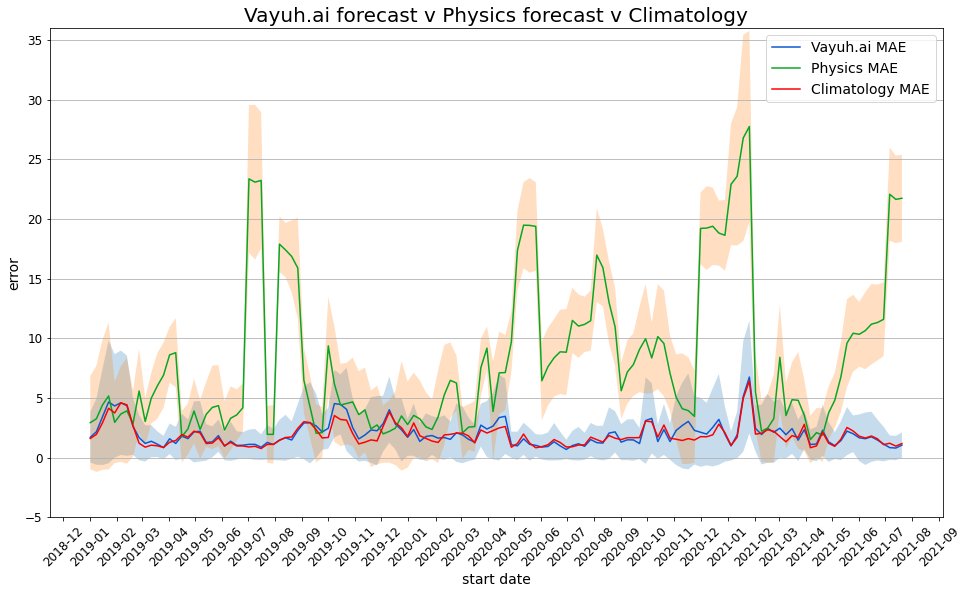

In [149]:
#Plots by time
fig = plt.figure(figsize=(16,9))
ax = plt.axes()
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Vayuh.ai forecast v Physics forecast v Climatology", fontsize=20)
plt.xlabel("start date", fontsize=14)
plt.ylabel("error", fontsize=14)
plt.ylim(-5,36)
ax.xaxis.set_major_locator(mdates.MonthLocator()) #set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #set major ticks format
plt.plot(chartdata2.index, chartdata2['Vayuh MAE'], color = '#0C58D3', label='Vayuh.ai MAE')
ax.fill_between(chartdata2.index, chartdata2['Vayuh MAE'] - chartdata2['Vayuh SD'], chartdata2['Vayuh MAE'] + chartdata2['Vayuh SD'], alpha=0.25)
plt.plot(chartdata2.index, chartdata2['Physics MAE'], color = '#06A723', label = 'Physics MAE')
ax.fill_between(chartdata2.index, chartdata2['Physics MAE'] - chartdata2['Physics SD'], chartdata2['Physics MAE'] + chartdata2['Physics SD'], alpha=0.25)
plt.plot(chartdata2.index, chartdata2['Climatology MAE'], color = 'red', label = 'Climatology MAE')
#ax.fill_between(chartdata2.index, chartdata2['Climatology MAE'] - chartdata2['Climatology SD'], chartdata2['Climatology MAE'] + chartdata2['Climatology SD'], alpha=0.25)
#ax.fill_between(chartdata.index, 0, 5, alpha=0.25)
plt.legend(prop={"size":14})
#fig.savefig('figs/'+'MAE'+'plot2.png', dpi = 300)

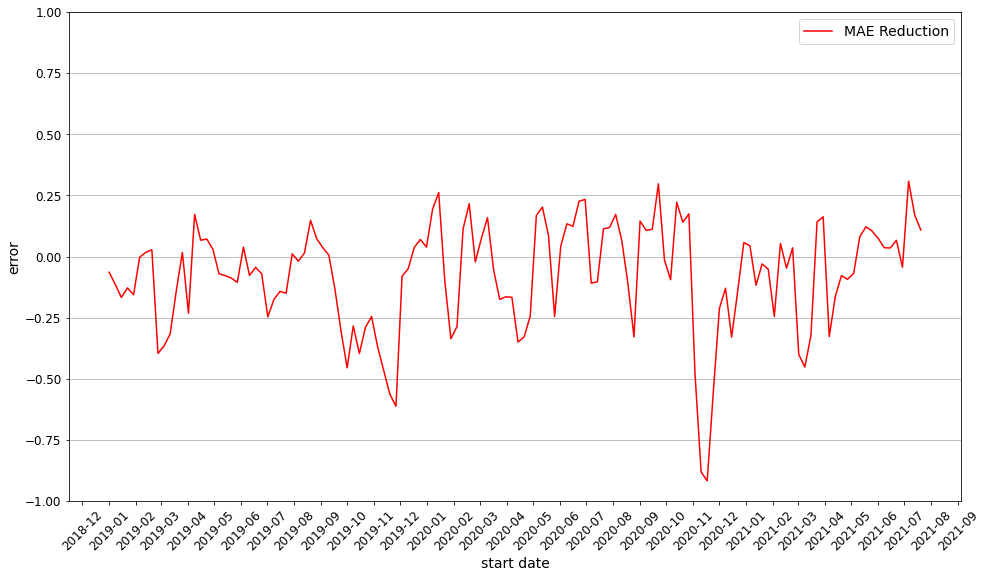

In [150]:
#Plot MAE reduction by time
fig = plt.figure(figsize=(16,9))
ax = plt.axes()
ax.grid(axis='y')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
#plt.title("MAE Reduction from Climatology over time", fontsize=20)
plt.xlabel("start date", fontsize=14)
plt.ylabel("error", fontsize=14)
plt.ylim(-1,1)
ax.xaxis.set_major_locator(mdates.MonthLocator()) #set ticks every week
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) #set major ticks format
plt.plot(chartdata2.index, chartdata2['MAE Reduction'], color = 'red', label = 'MAE Reduction')
plt.legend(prop={"size":14})
#fig.savefig('figs/'+'MAE'+'plot2.png', dpi = 300)

In [151]:
#Climatology comparisons by Season
indexlist = ['season']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata3 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata3 = pd.merge(chartdata3, climpivot, on=indexlist)
chartdata3['ml>clim'] = chartdata3['Vayuh MAE'] < chartdata3['Climatology MAE']
chartdata3['phys>clim'] = chartdata3['Physics MAE'] < chartdata3['Climatology MAE']
chartdata3['MAE Reduction'] = (chartdata3['Climatology MAE'] - chartdata3['Vayuh MAE'])/chartdata3['Climatology MAE']
chartdata3['MAE Reduction'] = round(chartdata3['MAE Reduction'],3)
chartdata3

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
season,,,,,,,,,,,,
fall,0.590,2.445,3.134,-1.406,5.686,6.792,-0.005,2.050,2.591,False,False,-0.193
spring,0.134,1.726,2.215,-6.145,6.513,5.966,-0.047,1.610,2.035,False,False,-0.072
summer,-0.225,1.260,1.622,-12.097,12.274,7.559,-0.531,1.294,1.598,True,False,0.026
winter,0.573,2.647,3.677,5.174,8.291,11.032,0.066,2.527,3.512,False,False,-0.047


In [152]:
#Climatology comparisons by Season / Year and month
indexlist = ['season','yearmonth']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata4 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata4 = pd.merge(chartdata4, climpivot, on=indexlist)
chartdata4['ml>clim'] = chartdata4['Vayuh MAE'] < chartdata4['Climatology MAE']
chartdata4['phys>clim'] = chartdata4['Physics MAE'] < chartdata4['Climatology MAE']
chartdata4['MAE Reduction'] = (chartdata4['Climatology MAE'] - chartdata4['Vayuh MAE'])/chartdata4['Climatology MAE']
chartdata4['MAE Reduction'] = round(chartdata4['MAE Reduction'],3)
#season filter
chartdata4.reset_index(inplace=True)
chartdata4 = chartdata4[chartdata4['season'] == 'summer']
chartdata4 = chartdata4.drop(columns=['season'])
chartdata4.set_index('yearmonth',inplace=True)
chartdata4

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
yearmonth,,,,,,,,,,,,
2019-06,-0.171,1.091,1.362,-2.857,3.330,2.558,-0.093,1.048,1.294,False,False,-0.041
2019-07,-0.360,1.083,1.291,-13.874,14.706,12.484,-0.362,0.954,1.143,False,False,-0.135
2019-08,-0.494,1.712,1.990,-17.002,17.002,3.154,-0.989,1.820,1.938,True,False,0.059
2020-06,-0.222,0.953,1.210,-8.016,8.016,3.518,-0.638,1.124,1.292,True,False,0.152
2020-07,-0.386,1.149,1.395,-11.281,11.281,2.572,-0.762,1.178,1.323,True,False,0.025
2020-08,0.663,1.660,2.038,-14.206,14.206,4.216,-0.022,1.563,1.942,False,False,-0.062
2021-06,-0.500,1.509,1.923,-11.005,11.005,3.157,-0.733,1.572,2.006,True,False,0.040
2021-07,-0.225,0.887,1.107,-21.807,21.807,3.748,-0.637,1.106,1.250,True,False,0.198


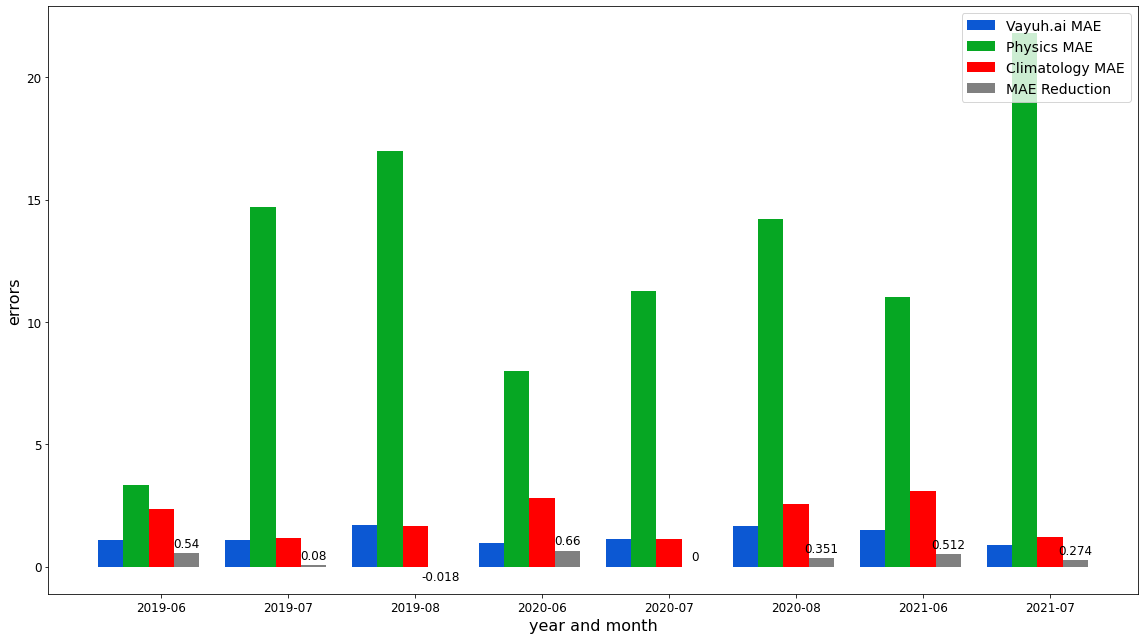

In [118]:
#figsize=(16,9)
fig = plt.figure(figsize=(16,9))
x = np.arange(len(chartdata4.index))  # the label locations
width = 0.2  # the width of the bars

ax = plt.axes()
rects1 = ax.bar(x - 2*width, chartdata4['Vayuh MAE'], width, label='Vayuh.ai MAE', color = '#0C58D3')
rects2 = ax.bar(x - width, chartdata4['Physics MAE'], width, label='Physics MAE', color = '#06A723')
rects3 = ax.bar(x, chartdata4['Climatology MAE'], width, label='Climatology MAE', color = 'red')
rects4 = ax.bar(x + width, chartdata4['MAE Reduction'], width, label='MAE Reduction', color = 'grey')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('errors', fontsize=16)
plt.xlabel("year and month", fontsize=16)
#ax.set_title('Vayuh.AI forecasts vs Physics forecasts', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(chartdata4.index, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend()

#ax.bar_label(rects1, padding=3, fontsize=10)
#ax.bar_label(rects2, padding=3, fontsize=7)
#ax.bar_label(rects3, padding=3, fontsize=7)
ax.bar_label(rects4, padding=3, fontsize=12)

fig.tight_layout()
plt.legend(prop={"size":14}, loc='upper right')
#plt.xticks(rotation=45, fontsize=10)
plt.show()
#fig.savefig('figs/'+'MAE_'+seasonchoice+'_'+'plot.png', dpi = 500)

In [119]:
#Climatology comparisons by Season / State
indexlist = ['season','State']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata4b = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata4b = pd.merge(chartdata4b, climpivot, on=indexlist)
chartdata4b['ml>clim'] = chartdata4b['Vayuh MAE'] < chartdata4b['Climatology MAE']
chartdata4b['phys>clim'] = chartdata4b['Physics MAE'] < chartdata4b['Climatology MAE']
chartdata4b['MAE Reduction'] = (chartdata4b['Climatology MAE'] - chartdata4b['Vayuh MAE'])/chartdata4b['Climatology MAE']
chartdata4b['MAE Reduction'] = round(chartdata4b['MAE Reduction'],3)
#season filter
chartdata4b.reset_index(inplace=True)
chartdata4b = chartdata4b[chartdata4b['season'] == 'winter']
chartdata4b = chartdata4b.drop(columns=['season'])
#chartdata4b.set_index('State',inplace=True)
chartdata4b

,State,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
129,Alabama,-0.280,2.307,2.816,2.986,6.763,8.971,-2.313,3.128,2.966,True,False,0.262
130,Arizona,1.278,1.649,1.710,3.233,7.203,9.575,-1.029,1.887,1.921,True,False,0.126
131,Arkansas,0.327,2.046,2.952,4.387,7.208,10.300,-1.339,2.753,3.220,True,False,0.257
132,California,1.003,1.664,1.989,3.391,6.948,8.753,-0.561,1.524,1.784,False,False,-0.092
133,Colorado,1.037,2.173,2.777,6.135,8.134,10.262,-1.106,2.714,3.108,True,False,0.199
134,Florida,0.237,1.961,2.358,2.810,4.407,5.280,-1.318,2.377,2.586,True,False,0.175
135,Georgia,-0.143,2.179,2.732,2.810,6.589,8.395,-2.217,2.916,2.688,True,False,0.253
136,Idaho,0.632,2.383,2.954,3.613,7.930,10.544,-1.141,2.165,2.522,False,False,-0.101
137,Illinois,0.935,2.847,3.606,6.872,8.838,11.638,-0.942,3.180,3.976,True,False,0.105
138,Indiana,-0.020,2.408,3.071,5.787,7.999,10.981,-1.432,2.948,3.274,True,False,0.183


In [120]:
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata4b, on='State')
gdf

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,geometry,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
0,37,01027616,0400000US37,37,NC,North Carolina,00,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",-0.163,1.821,2.195,2.886,7.152,9.637,-1.778,2.659,2.654,True,False,0.315
1,40,01102857,0400000US40,40,OK,Oklahoma,00,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",0.635,2.410,3.682,5.881,7.438,10.564,-0.997,2.840,3.783,True,False,0.151
2,51,01779803,0400000US51,51,VA,Virginia,00,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ...",-0.125,1.809,2.276,3.127,7.499,10.323,-1.796,2.743,2.748,True,False,0.341
3,54,01779805,0400000US54,54,WV,West Virginia,00,"POLYGON ((-82.64320 38.16909, -82.64300 38.169...",-0.571,1.781,2.212,3.320,7.983,11.047,-1.494,2.930,3.117,True,False,0.392
4,22,01629543,0400000US22,22,LA,Louisiana,00,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ...",0.002,1.880,2.634,3.560,6.370,8.923,-1.393,2.708,2.949,True,False,0.306
5,26,01779789,0400000US26,26,MI,Michigan,00,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ...",-0.609,2.691,3.196,5.434,7.984,10.418,-1.253,2.925,3.471,True,False,0.080
6,16,01779783,0400000US16,16,ID,Idaho,00,"POLYGON ((-117.24267 44.39655, -117.23484 44.3...",0.632,2.383,2.954,3.613,7.930,10.544,-1.141,2.165,2.522,False,False,-0.101
7,12,00294478,0400000US12,12,FL,Florida,00,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ...",0.237,1.961,2.358,2.810,4.407,5.280,-1.318,2.377,2.586,True,False,0.175
8,31,01779792,0400000US31,31,NE,Nebraska,00,"POLYGON ((-104.05342 41.17054, -104.05324 41.1...",1.590,3.926,5.004,7.084,10.259,12.726,-0.689,4.010,5.133,True,False,0.021
9,53,01779804,0400000US53,53,WA,Washington,00,"MULTIPOLYGON (((-122.57039 48.53785, -122.5686...",1.043,2.743,3.621,2.324,8.178,10.561,-0.907,2.616,3.003,False,False,-0.049


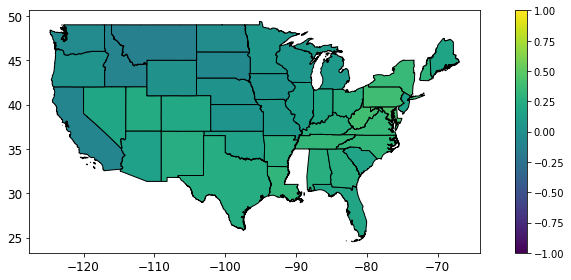

In [121]:
#Plot by season by State
fig, axes = plt.subplots(figsize=(10,4))
gdf.plot(ax=axes, column='MAE Reduction', cmap='viridis', vmax=1, vmin=-1, linewidth=1, edgecolor='black', legend=True)
#axes.set_title('Vayuh.ai MAE', fontsize=20)
axes.tick_params(labelsize=12)
fig.tight_layout()

In [153]:
#Climatology comparisons by Yearmonth
indexlist = ['year', 'month2']

vayuhpivot = pd.pivot_table(data=df_test2, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test2, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test2, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata5 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata5 = pd.merge(chartdata5, climpivot, on=indexlist)
chartdata5['ml>clim'] = chartdata5['Vayuh MAE'] < chartdata5['Climatology MAE']
chartdata5['phys>clim'] = chartdata5['Physics MAE'] < chartdata5['Climatology MAE']
chartdata5['MAE Reduction'] = (chartdata5['Climatology MAE'] - chartdata5['Vayuh MAE'])/chartdata5['Climatology MAE']
chartdata5['MAE Reduction'] = round(chartdata5['MAE Reduction'],3)
chartdata5

Vayuh MBE  Vayuh MAE  Vayuh SD  Physics MBE  Physics MAE  \
year month2                                                             
2019 01          2.373      3.243     3.931        1.907        3.734   
     02          2.839      3.300     3.671       -1.218        3.991   
     03         -0.532      1.121     1.326       -5.120        5.225   
     04          0.154      1.652     2.022       -4.752        5.083   
     05          0.962      1.653     1.798       -3.430        3.631   
     06         -0.171      1.091     1.362       -2.857        3.330   
     07         -0.360      1.083     1.291      -13.874       14.706   
     08         -0.494      1.712     1.990      -17.002       17.002   
     09          0.642      2.648     3.033       -2.435        3.717   
     10          3.201      3.589     2.856       -5.492        5.820   
     11         -0.674      1.998     2.481        1.731        3.178   
     12         -2.152      2.731     2.528        0.499        2.575   
2020 01         -0.044      1.823     2.261       -2.112        2.921   
     02         -0.133      1.724     2.139       -4.741        5.338   
     03          1.054      1.960     2.261       -4.567        4.779   
     04          0.902      2.625     3.053       -5.593        6.937   
     05         -0.280      1.165     1.428      -18.914       18.914   
     06         -0.222      0.953     1.210       -8.016        8.016   
     07         -0.386      1.149     1.395      -11.281       11.281   
     08          0.663      1.660     2.038      -14.206       14.206   
     09          0.634      1.702     2.329        7.859        7.912   
     10         -0.005      2.072     2.656       -8.762        8.772   
     11         -0.923      2.561     3.420       -2.634        4.130   
     12         -0.676      2.351     3.069       19.047       19.047   
2021 01          3.166      3.680     4.361       25.245       25.245   
     02         -0.248      2.230     2.891        1.283        3.358   
     03         -0.712      2.114     2.523       -4.648        5.018   
     04          0.564      1.449     1.755       -1.518        2.302   
     05         -0.924      1.652     1.945       -7.880        7.889   
     06         -0.500      1.509     1.923      -11.005       11.005   
     07         -0.225      0.887     1.107      -21.807       21.807   

             Physics SD  Climatology MBE  Climatology MAE  Climatology SD  \
year month2                                                                 
2019 01           4.828            1.805            2.859           3.588   
     02           4.703            2.878            3.216           3.411   
     03           2.851           -0.300            0.929           1.117   
     04           4.121            0.392            1.705           1.998   
     05           3.212            0.500            1.524           1.771   
     06           2.558           -0.093            1.048           1.294   
     07          12.484           -0.362            0.954           1.143   
     08           3.154           -0.989            1.820           1.938   
     09           3.938           -0.046            2.477           2.951   
     10           4.450            1.944            2.704           2.585   
     11           3.630           -0.408            1.322           1.581   
     12           3.461           -2.216            2.721           2.376   
2020 01           3.157           -0.861            1.927           2.269   
     02           3.924           -0.807            1.781           2.075   
     03           3.775            0.513            1.886           2.278   
     04           5.427            0.204            2.049           2.481   
     05           3.765           -0.815            1.290           1.440   
     06           3.518           -0.638            1.124           1.292   
     07           2.572           -0.762            1.178      

In [123]:
#Climatology comparisons during heatwaves / coldwaves
df_test3 = df_test2[df_test2['coldwave']]
indexlist = ['State']

vayuhpivot = pd.pivot_table(data=df_test3, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test3, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test3, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata6a = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata6a = pd.merge(chartdata6a, climpivot, on=indexlist)
chartdata6a['ml>clim'] = chartdata6a['Vayuh MAE'] < chartdata6a['Climatology MAE']
chartdata6a['phys>clim'] = chartdata6a['Physics MAE'] < chartdata6a['Climatology MAE']
chartdata6a['MAE Reduction'] = (chartdata6a['Climatology MAE'] - chartdata6a['Vayuh MAE'])/chartdata6a['Climatology MAE']
chartdata6a['MAE Reduction'] = round(chartdata6a['MAE Reduction'],3)
chartdata6a

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
State,,,,,,,,,,,,
Colorado,4.672,4.672,2.958,11.396,11.396,9.127,4.419,4.485,2.591,False,False,-0.042
Illinois,9.446,9.446,1.670,27.849,27.849,10.883,7.838,7.838,1.221,False,False,-0.205
Iowa,7.406,7.406,3.282,18.134,18.134,13.814,5.808,5.808,2.861,False,False,-0.275
Kansas,12.504,12.504,0.337,36.226,36.226,1.004,10.080,10.080,0.153,False,False,-0.240
Maine,1.140,1.769,1.591,7.213,9.678,13.608,0.123,1.593,1.794,False,False,-0.110
Michigan,4.808,4.808,1.270,15.326,15.326,11.695,4.211,4.211,1.474,False,False,-0.142
Minnesota,4.524,5.199,3.944,14.530,15.362,13.853,4.365,4.683,3.370,False,False,-0.110
Missouri,11.784,11.784,0.974,34.403,34.403,0.509,9.442,9.442,1.190,False,False,-0.248
Montana,12.178,12.178,3.627,16.885,16.901,13.981,10.533,10.533,3.354,False,False,-0.156


In [124]:
#texas cold wave (06 Feb to 22 Feb 2021) (14 day differences)
texascoldwave = df_test2[(df_test2['start_date']>='2021-01-23') & (df_test2['start_date']<='2021-02-28')]

indexlist = ['State']

vayuhpivot = pd.pivot_table(data=texascoldwave, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=texascoldwave, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=texascoldwave, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata7a = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata7a = pd.merge(chartdata7a, climpivot, on=indexlist)
chartdata7a['ml>clim'] = chartdata7a['Vayuh MAE'] < chartdata7a['Climatology MAE']
chartdata7a['phys>clim'] = chartdata7a['Physics MAE'] < chartdata7a['Climatology MAE']
chartdata7a['MAE Reduction'] = (chartdata7a['Climatology MAE'] - chartdata7a['Vayuh MAE'])/chartdata7a['Climatology MAE']
chartdata7a['MAE Reduction'] = round(chartdata7a['MAE Reduction'],3)
chartdata7a
#chartdata7a[chartdata7a['MAE Reduction']<0]

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
State,,,,,,,,,,,,
Alabama,1.031,2.043,2.533,1.169,6.795,9.517,-2.318,3.154,2.550,True,False,0.352
Arizona,1.960,2.058,1.367,5.326,5.795,6.903,-1.329,1.329,0.745,False,False,-0.549
Arkansas,2.107,4.225,5.206,4.494,9.284,13.229,-1.151,5.553,6.041,True,False,0.239
California,2.264,2.273,1.548,7.364,7.364,4.930,-0.119,0.841,1.023,False,False,-1.703
Colorado,2.176,2.664,3.497,8.691,8.874,10.170,-1.696,3.513,3.881,True,False,0.242
Florida,-0.146,1.362,1.616,1.745,1.954,2.621,-2.604,2.729,1.953,True,True,0.501
Georgia,0.154,0.762,0.910,0.435,5.793,7.746,-2.777,2.777,0.895,True,False,0.726
Idaho,1.447,1.599,1.341,7.081,7.593,9.238,-1.334,1.957,2.180,True,False,0.183
Illinois,1.361,4.404,5.285,7.065,9.430,13.796,-2.706,6.117,6.308,True,False,0.280


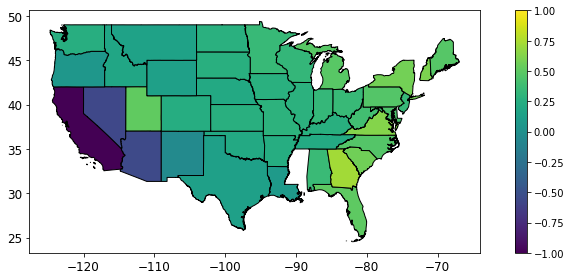

In [125]:
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata7a, on='State')
fig, axes = plt.subplots(figsize=(10,4))
gdf.plot(ax=axes, column='MAE Reduction', cmap='viridis', vmax=1, vmin=-1, linewidth=1, edgecolor='black', legend=True)
#axes.set_title('Vayuh.ai MAE', fontsize=20)
axes.tick_params(labelsize=12)
fig.tight_layout()

In [126]:
#texas cold wave - specifically in texas
df_test3 = df_test2[df_test2['State']=='Texas']
tcounties = pd.read_csv('tcounties.csv', encoding='utf-8')
tcounties = tcounties[tcounties.latlon.notnull()]
df_test3 = pd.merge(df_test3, tcounties, on='latlon')
df_test3

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,heatwave,coldwave,mdll,climatology,clim_err,ml_outperforms_climatology,phys_outperforms_climatology,abs_clim_err,abs_err,county
0,2019-10-01|27.25|261.75,2019-10-01,27.25,261.75,1.028229,22.870967,2.045002,-0.014837,22.840626,24.973697,...,False,False,10|01|27.25|261.75,26.046652,3.206026,True,False,3.206026,2.133,Falfurrias
1,2019-10-08|27.25|261.75,2019-10-08,27.25,261.75,1.093624,21.721882,1.985609,-1.286955,19.166492,23.893391,...,False,False,10|08|27.25|261.75,24.252977,5.086485,True,True,5.086485,4.727,Falfurrias
2,2019-10-15|27.25|261.75,2019-10-15,27.25,261.75,1.043933,20.675154,2.121438,-1.040800,18.467161,22.889792,...,False,False,10|15|27.25|261.75,24.302401,5.835239,True,True,5.835239,4.423,Falfurrias
3,2019-10-22|27.25|261.75,2019-10-22,27.25,261.75,0.892237,19.451975,2.304340,-1.896681,15.081376,21.507993,...,False,False,10|22|27.25|261.75,22.604475,7.523099,True,True,7.523099,6.427,Falfurrias
4,2019-10-29|27.25|261.75,2019-10-29,27.25,261.75,0.883454,18.518180,2.384524,-1.176233,15.713424,20.624798,...,False,False,10|29|27.25|261.75,21.669365,5.955941,True,True,5.955941,4.911,Falfurrias
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021-06-29|35.25|259.75,2021-06-29,35.25,259.75,-0.013323,27.746733,1.806241,-0.526073,26.796518,27.722669,...,False,False,06|29|35.25|259.75,26.487171,-0.309347,False,False,0.309347,0.926,Shamrock
2274,2020-07-07|35.25|259.75,2020-07-07,35.25,259.75,0.136900,27.540796,1.872228,-0.307083,26.965866,27.797105,...,False,False,07|07|35.25|259.75,27.467903,0.502037,False,False,0.502037,0.831,Shamrock
2275,2020-07-14|35.25|259.75,2020-07-14,35.25,259.75,-0.027322,27.412121,1.786003,-0.168923,27.110424,27.363325,...,False,False,07|14|35.25|259.75,27.128654,0.018230,False,False,0.018230,0.253,Shamrock
2276,2020-07-21|35.25|259.75,2020-07-21,35.25,259.75,-0.223790,26.877615,1.705078,0.827138,28.287951,26.496036,...,False,False,07|21|35.25|259.75,28.418047,0.130096,False,False,0.130096,1.792,Shamrock


In [127]:
df_test3_texas = df_test3[(df_test3['start_date']>='2021-01-23') & (df_test3['start_date']<='2021-02-28')]

indexlist = ['county']

vayuhpivot = pd.pivot_table(data=df_test3_texas, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test3_texas, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test3_texas, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata8 = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata8 = pd.merge(chartdata8, climpivot, on=indexlist)
chartdata8['ml>clim'] = chartdata8['Vayuh MAE'] < chartdata8['Climatology MAE']
chartdata8['phys>clim'] = chartdata8['Physics MAE'] < chartdata8['Climatology MAE']
chartdata8['MAE Reduction'] = (chartdata8['Climatology MAE'] - chartdata8['Vayuh MAE'])/chartdata8['Climatology MAE']
chartdata8['MAE Reduction'] = round(chartdata8['MAE Reduction'],3)
chartdata8
#chartdata7a[chartdata7a['MAE Reduction']<0]

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
county,,,,,,,,,,,,
Adamsville,2.789,4.304,5.557,6.251,8.081,11.618,0.360,4.706,6.022,True,False,0.085
Aspermont North,3.256,4.574,6.047,7.950,9.335,13.110,-0.115,5.699,7.029,True,False,0.197
Brackettville,2.844,3.294,4.417,3.130,7.400,10.419,-0.120,3.521,4.497,True,False,0.064
Broaddus,2.131,3.254,4.374,3.576,7.387,11.056,-0.592,3.682,4.360,True,False,0.116
Brownfield,3.178,4.061,5.159,7.806,8.643,11.776,0.025,4.417,5.536,True,False,0.081
Celeste,3.493,4.571,5.885,6.546,8.934,13.062,-0.143,5.323,6.384,True,False,0.141
El Campo,2.563,3.218,4.429,4.244,6.372,9.576,-0.227,3.689,4.579,True,False,0.128
Falfurrias,2.885,3.261,4.442,4.369,6.196,9.370,-0.041,3.573,4.516,True,False,0.087
Floresville,2.790,3.793,5.027,4.486,7.108,10.363,0.894,3.761,5.020,False,False,-0.009


In [128]:
gdft = gpd.read_file('./tl_2016_48_cousub/tl_2016_48_cousub.shp')
gdft = gdft.drop(columns=['ALAND', 'AWATER', 'CNECTAFP', 'NECTAFP', 'NCTADVFP', 'FUNCSTAT', 'INTPTLAT', 'INTPTLON'])
gdft = gdft.rename(columns={'NAME':'county'})
gdft = gdft.merge(chartdata8, on='county', how='left')
gdft['MAE Reduction'] = gdft['MAE Reduction'].fillna(0)
gdft

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,county,NAMELSAD,LSAD,CLASSFP,MTFCC,...,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
0,48,423,93950,01939272,4842393950,Troup-Arp,Troup-Arp CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,48,423,94205,01939323,4842394205,Whitehouse,Whitehouse CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,48,423,93970,01939276,4842393970,Tyler,Tyler CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,48,423,94260,01939334,4842394260,Winona,Winona CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,48,039,90094,01938494,4803990094,Angleton,Angleton CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,48,131,93215,01939124,4813193215,Realitos-Concepcion,Realitos-Concepcion CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
858,48,131,90260,01938527,4813190260,Benavides,Benavides CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
859,48,277,92970,01939075,4827792970,Paris,Paris CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
860,48,053,90450,01938565,4805390450,Briggs,Briggs CCD,22,Z5,G4040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


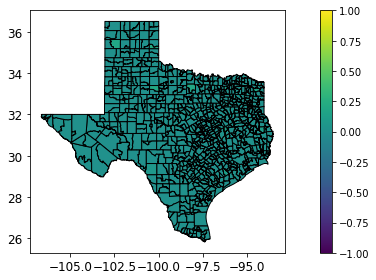

In [129]:
fig, axes = plt.subplots(figsize=(10,4))
gdft.plot(ax=axes, column='MAE Reduction', cmap='viridis', vmax=1, vmin=-1, linewidth=1, edgecolor='black', legend=True)
#axes.set_title('Vayuh.ai MAE', fontsize=20)
axes.tick_params(labelsize=12)
fig.tight_layout()

In [130]:
#oregon heat wave (28 Jun to 15 Jul 2021) (14 day differences)
oregonheatwave = df_test2[(df_test2['start_date']>='2021-06-14') & (df_test2['start_date']<='2021-07-01')]

indexlist = ['State']

vayuhpivot = pd.pivot_table(data=oregonheatwave, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=oregonheatwave, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=oregonheatwave, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata7b = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata7b = pd.merge(chartdata7b, climpivot, on=indexlist)
chartdata7b['ml>clim'] = chartdata7b['Vayuh MAE'] < chartdata7b['Climatology MAE']
chartdata7b['phys>clim'] = chartdata7b['Physics MAE'] < chartdata7b['Climatology MAE']
chartdata7b['MAE Reduction'] = (chartdata7b['Climatology MAE'] - chartdata7b['Vayuh MAE'])/chartdata7b['Climatology MAE']
chartdata7b['MAE Reduction'] = round(chartdata7b['MAE Reduction'],3)
chartdata7b
#chartdata7b[chartdata7b['MAE Reduction']<0]

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
State,,,,,,,,,,,,
Alabama,1.042,1.042,0.547,-7.280,7.280,0.935,-0.228,0.550,0.656,False,False,-0.895
Arizona,-0.680,1.495,1.585,-10.859,10.859,2.201,-2.900,3.417,2.719,True,False,0.562
Arkansas,1.183,1.183,0.343,-10.483,10.483,0.996,0.018,0.353,0.462,False,False,-2.351
California,-1.488,1.565,1.051,-10.598,10.598,3.484,-4.712,4.712,1.905,True,False,0.668
Colorado,-0.686,1.113,1.242,-10.751,10.751,2.192,-2.530,2.551,1.791,True,False,0.564
Florida,0.459,0.506,0.408,-3.289,3.289,0.625,0.032,0.404,0.533,False,False,-0.252
Georgia,1.072,1.072,0.406,-8.548,8.548,1.294,-0.311,0.427,0.433,False,False,-1.511
Idaho,-3.148,3.148,1.473,-17.542,17.542,2.590,-7.009,7.009,2.559,True,False,0.551
Illinois,1.164,1.164,0.575,-10.601,10.601,0.641,-0.157,0.514,0.596,False,False,-1.265


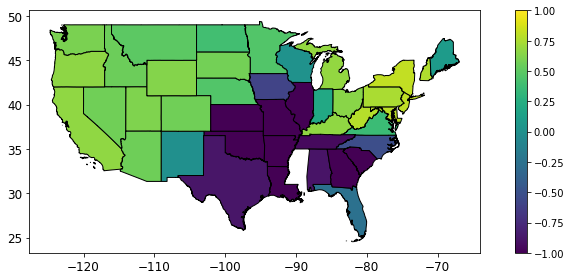

In [131]:
#Get shapefile into geopandas dataframe and merge in forecasts
gdf = gpd.read_file('./us_states/cb_2018_us_state_500k.shp')
gdf = gdf.drop(columns=['ALAND', 'AWATER'])
gdf = gdf.rename(columns={"NAME":"State"})
gdf = gdf.merge(chartdata7b, on='State')
fig, axes = plt.subplots(figsize=(10,4))
gdf.plot(ax=axes, column='MAE Reduction', cmap='viridis', vmax=1, vmin=-1, linewidth=1, edgecolor='black', legend=True)
#axes.set_title('Vayuh.ai MAE', fontsize=20)
axes.tick_params(labelsize=12)
fig.tight_layout()

In [132]:
#oregon heatwave specifically in oregon
#texas cold wave - specifically in texas
df_test4 = df_test2[df_test2['State']=='Oregon']
ocounties = pd.read_csv('ocounties.csv', encoding='utf-8')
ocounties = ocounties[ocounties.latlon.notnull()]
df_test4 = pd.merge(df_test4, ocounties, on='latlon')
df_test4

,key,start_date,lat,lon,xgboost_tmp2m_pred_zscore,tmp2m_daily_mean,tmp2m_daily_std,tmp2m_zscore,tmp2m,xgboost_tmp2m_pred,...,heatwave,coldwave,mdll,climatology,clim_err,ml_outperforms_climatology,phys_outperforms_climatology,abs_clim_err,abs_err,county
0,2019-10-01|43.25|237.75,2019-10-01,43.25,237.75,0.449952,5.896098,1.549751,-0.625541,4.926665,6.593412,...,False,False,10|01|43.25|237.75,9.885308,4.958643,True,False,4.958643,1.667,Douglas
1,2019-10-08|43.25|237.75,2019-10-08,43.25,237.75,0.470379,4.280001,1.580677,-0.751434,3.092227,5.023518,...,False,False,10|08|43.25|237.75,8.377697,5.285470,True,True,5.285470,1.931,Douglas
2,2019-10-15|43.25|237.75,2019-10-15,43.25,237.75,0.356878,2.833536,1.675758,-0.023981,2.793350,3.431578,...,False,False,10|15|43.25|237.75,6.939498,4.146148,True,True,4.146148,0.638,Douglas
3,2019-10-22|43.25|237.75,2019-10-22,43.25,237.75,0.297970,1.933407,1.860651,1.138649,4.052035,2.487825,...,False,False,10|22|43.25|237.75,6.129072,2.077037,True,False,2.077037,1.564,Douglas
4,2019-10-29|43.25|237.75,2019-10-29,43.25,237.75,0.259802,0.837439,1.897372,0.646368,2.063838,1.330379,...,False,False,10|29|43.25|237.75,4.154099,2.090261,True,False,2.090261,0.733,Douglas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799,2021-06-29|45.25|241.75,2021-06-29,45.25,241.75,0.545809,17.365234,2.129183,0.854694,19.185034,18.527361,...,False,False,06|29|45.25|241.75,15.759150,-3.425884,True,False,3.425884,0.658,Union
800,2020-07-07|45.25|241.75,2020-07-07,45.25,241.75,0.168117,17.983185,1.877162,1.090478,20.030188,18.298768,...,False,False,07|07|45.25|241.75,16.328878,-3.701309,True,False,3.701309,1.731,Union
801,2020-07-14|45.25|241.75,2020-07-14,45.25,241.75,0.267660,18.034045,1.915378,0.598070,19.179575,18.546715,...,False,False,07|14|45.25|241.75,17.005629,-2.173946,True,False,2.173946,0.633,Union
802,2020-07-21|45.25|241.75,2020-07-21,45.25,241.75,0.416143,17.577900,1.920596,-0.235718,17.125181,18.377143,...,False,False,07|21|45.25|241.75,17.445768,0.320587,False,False,0.320587,1.252,Union


In [133]:
df_test4_oregon = df_test4[(df_test4['start_date']>='2021-06-14') & (df_test4['start_date']<='2021-07-01')]

indexlist = ['county']

vayuhpivot = pd.pivot_table(data=df_test4_oregon, index=indexlist, values='err', aggfunc=[mbe,mae,sd])
vayuhpivot.columns = list(map("_".join, vayuhpivot.columns))
vayuhpivot.rename(columns={"mbe_err":"Vayuh MBE", "mae_err":"Vayuh MAE", "sd_err":"Vayuh SD"}, inplace=True)
vayuhpivot

physicspivot = pd.pivot_table(data=df_test4_oregon, index=indexlist, values='phys_err', aggfunc=[mbe,mae,sd])
physicspivot.columns = list(map("_".join, physicspivot.columns))
physicspivot.rename(columns={"mbe_phys_err":"Physics MBE", "mae_phys_err":"Physics MAE", "sd_phys_err":"Physics SD"}, inplace=True)
physicspivot

climpivot = pd.pivot_table(data=df_test4_oregon, index=indexlist, values='clim_err', aggfunc=[mbe,mae,sd])
climpivot.columns = list(map("_".join, climpivot.columns))
climpivot.rename(columns={"mbe_clim_err":"Climatology MBE", "mae_clim_err":"Climatology MAE", "sd_clim_err":"Climatology SD"}, inplace=True)
climpivot

chartdata8b = pd.merge(vayuhpivot, physicspivot, on=indexlist)
chartdata8b = pd.merge(chartdata8b, climpivot, on=indexlist)
chartdata8b['ml>clim'] = chartdata8b['Vayuh MAE'] < chartdata8b['Climatology MAE']
chartdata8b['phys>clim'] = chartdata8b['Physics MAE'] < chartdata8b['Climatology MAE']
chartdata8b['MAE Reduction'] = (chartdata8b['Climatology MAE'] - chartdata8b['Vayuh MAE'])/chartdata8b['Climatology MAE']
chartdata8b['MAE Reduction'] = round(chartdata8b['MAE Reduction'],3)
chartdata8b
#chartdata7a[chartdata7a['MAE Reduction']<0]

,Vayuh MBE,Vayuh MAE,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
county,,,,,,,,,,,,
Clackamas,-0.497,0.497,0.595,-10.515,10.515,0.343,-3.777,3.777,1.628,True,False,0.868
Douglas,-1.422,1.422,1.106,-8.757,8.757,0.650,-5.259,5.259,2.144,True,False,0.730
Gilliam,-2.425,2.425,1.134,-14.929,14.929,0.645,-6.773,6.773,2.320,True,False,0.642
Harney,-3.082,3.082,1.366,-14.056,14.056,0.739,-7.001,7.001,2.385,True,False,0.560
Lake,-2.532,2.532,1.267,-13.850,13.850,0.705,-6.066,6.066,2.333,True,False,0.583
Union,-2.074,2.074,1.230,-11.073,11.073,0.810,-6.524,6.524,2.485,True,False,0.682


In [134]:
gdfo = gpd.read_file('./orcnty2015/orcntypoly.shp')
gdfo = gdfo.drop(columns=['SHAPE_Leng', 'SHAPE_Area'])
gdfo = gdfo.rename(columns={'altName':'county'})
gdfo = gdfo.merge(chartdata8b, on='county', how='left')
gdfo['MAE Reduction'] = gdfo['MAE Reduction'].fillna(0)
gdfo

,OBJECTID,unitID,instName,county,descriptn,instCode,codeRef,effDate,unitOwner,cSteward,...,Vayuh SD,Physics MBE,Physics MAE,Physics SD,Climatology MBE,Climatology MAE,Climatology SD,ml>clim,phys>clim,MAE Reduction
0,1,1155133033,Josephine County,Josephine,http://www.leg.state.or.us/ors/201.html - 201....,033,FIPS Code,18590214,1155133,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1,1,1155129015,Curry County,Curry,http://www.leg.state.or.us/ors/201.html - 201....,015,FIPS Code,1999,1155129,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2,1,1135853029,Jackson County,Jackson,http://www.leg.state.or.us/ors/201.html - 201....,029,FIPS Code,18590214,1135853,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
3,1,1135848011,Coos County,Coos,http://www.leg.state.or.us/ors/201.html - 201....,011,FIPS Code,1983,1135848,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,1,1155134035,Klamath County,Klamath,http://www.leg.state.or.us/ors/201.html - 201....,035,FIPS Code,18590214,1155134,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
5,1,1135854037,Lake County,Lake,http://www.leg.state.or.us/ors/201.html - 201....,037,FIPS Code,18590214,1135854,BLM,...,1.267,-13.850,13.850,0.705,-6.066,6.066,2.333,True,False,0.583
6,1,1135849019,Douglas County,Douglas,http://www.leg.state.or.us/ors/201.html - 201....,019,FIPS Code,1983,1135849,BLM,...,1.106,-8.757,8.757,0.650,-5.259,5.259,2.144,True,False,0.730
7,1,1135852025,Harney County,Harney,http://www.leg.state.or.us/ors/201.html - 201....,025,FIPS Code,18590214,1135852,BLM,...,1.366,-14.056,14.056,0.739,-7.001,7.001,2.385,True,False,0.560
8,1,1135855039,Lane County,Lane,http://www.leg.state.or.us/ors/201.html - 201....,039,FIPS Code,20030108,1135855,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
9,1,1155130017,Deschutes County,Deschutes,http://www.leg.state.or.us/ors/201.html - 201....,017,FIPS Code,18590214,1155130,BLM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000


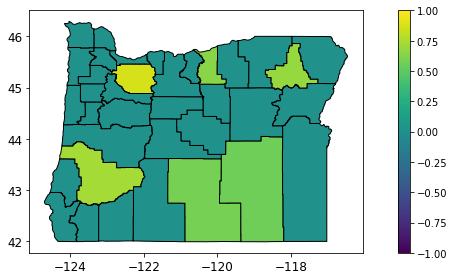

In [135]:
fig, axes = plt.subplots(figsize=(10,4))
gdfo.plot(ax=axes, column='MAE Reduction', cmap='viridis', vmax=1, vmin=-1, linewidth=1, edgecolor='black', legend=True)
#axes.set_title('Vayuh.ai MAE', fontsize=20)
axes.tick_params(labelsize=12)
fig.tight_layout()